# Интервенция в библиотеке DoWhy.

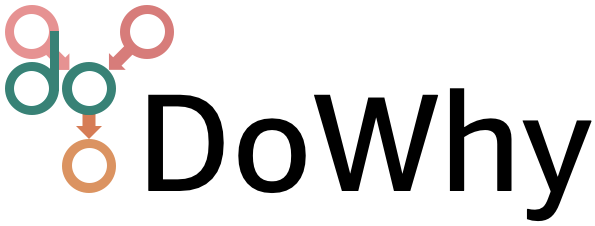

`DoWhy` &mdash; библиотека для анализа и оценки причинно-следственных выводов, предоставляет широкий спектр методов для оценки эффекта, изучения и диагностики причинно-следственной структуры данных.

Разрабатывается Microsoft с 2019 года, значительное улучшение получила в 2022 году. Также с 2022 была включена в совместный с Amazon проект `PyWhy`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import graphviz as gr

import networkx as nx
from dowhy import gcm  # Graphical Causal Models

## 1. Синтетические данные

Зададим граф из трех вершин и двух ориентированных ребер. В качестве названий вершин можно указывать любые строки

In [2]:
causal_graph = nx.DiGraph([
    ('X', 'Y'), 
    ('Y', 'Z')
])

Визуализируем граф

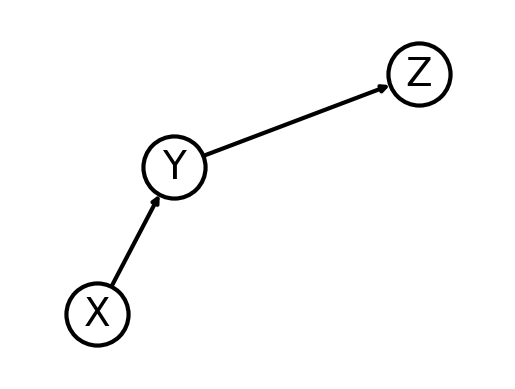

In [3]:
options = {
    "font_size": 28,
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
}

nx.draw_networkx(causal_graph, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

Список вершин

In [4]:
causal_graph.nodes

NodeView(('X', 'Y', 'Z'))

Список ребер

In [5]:
causal_graph.edges

OutEdgeView([('X', 'Y'), ('Y', 'Z')])

Сгенерируем данные

In [6]:
X = np.random.normal(loc=0, scale=1, size=1000)
Y = 2 * X + np.random.normal(loc=0, scale=1, size=1000)
Z = 3 * Y + np.random.normal(loc=0, scale=1, size=1000)

data = pd.DataFrame(data=dict(X=X, Y=Y, Z=Z))
data.head()

,X,Y,Z
0,0.027884,-1.353360,-3.496388
1,0.169650,0.741298,3.620634
2,-0.301648,-0.965703,-1.469203
3,0.276145,-0.394864,-0.871894
4,1.452683,3.784963,9.576385


Зададим Causal-модель по графу

In [7]:
causal_model = gcm.StructuralCausalModel(causal_graph)

### Способы задания моделей данных

**1. Явное указание моделей**

Можно задать модели вручную. 

Здесь мы сказали, что случайная величина $X$ моделируется эмпирическим распределением, а случайные величины $Y$ и $Z$ с помощью линейной зависимости (`create_linear_regressor`) от непосредственных родителей и аддитивного шума (`AdditiveNoiseModel`). Например, в случае величины $Y$ это означает зависимость $Y = a + bX + \varepsilon$.

В `AdditiveNoiseModel` можно передавать и другие модели. Например, для классификации можно передать `create_logistic_regression_classifier`. Также DoWhy поддерживает случайный лес и регрессии с l1-, l2- и ElasticNet-регуляризацией.

In [8]:
causal_model.set_causal_mechanism(
    'X', gcm.EmpiricalDistribution()
)
causal_model.set_causal_mechanism(
    'Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor())
)
causal_model.set_causal_mechanism(
    'Z', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor())
)

Обучаем модель.

Обучается отдельно каждая связь. В нашем случае их 3.

In [9]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node Z: 100%|████████| 3/3 [00:00<00:00, 166.18it/s]


Теперь можно выполнить интервенцию, сделав выборку из нового распределения. В данном случае мы выполнили интервенцию $Y := 2.34$. Тем самым случайная величина $X$ будет генерироваться прежним образом, потому как $Y$ на нее не оказывает влияния, а $Z$ будет генерироваться с учетом зафиксированного значения $Y$. Возможности библиотеки позволяют проводить интервенцию сложным образом, устанавливая произвольные сложные зависимости на величину $Y$.

In [10]:
samples = gcm.interventional_samples(
    causal_model,
    {'Y': lambda y: 2.34 },  # условие интервенции
    num_samples_to_draw=100_000  # количество семплирований
)
samples.head()

,X,Y,Z
0,0.442490,2.34,5.623677
1,-0.787618,2.34,7.189543
2,0.654774,2.34,6.493241
3,1.220488,2.34,6.848435
4,1.033126,2.34,7.499066


Посмотрим на средние полученных величин

In [11]:
samples.mean()

X    0.058678
Y    2.340000
Z    6.970046
dtype: float64

А также на средние в исходных данных

In [12]:
data.mean()

X    0.056831
Y    0.136852
Z    0.406956
dtype: float64

Как видим, средние $X$ почти не отличаются, ведь $Y$ на него не влияет, а среднее $Z$ стало другим.

---

Посмотрим также на то, какие модели у нас обучились.

На признак $X$ ничего не влияет, поэтому мы обучали эмпирическое распределение

In [13]:
model_X = causal_model.causal_mechanism('X')
model_X

Это распределение задается простым сохранением всех обучающих данных

In [14]:
model_X.data[:10]

array([[ 0.02788441],
       [ 0.16965016],
       [-0.30164837],
       [ 0.27614496],
       [ 1.4526834 ],
       [ 0.92305125],
       [ 1.62090155],
       [-0.62763152],
       [-0.85703266],
       [-1.22765404]])

Для величины $Y$ мы обучали линейную модель с аддитивным шумом

In [15]:
model_Y = causal_model.causal_mechanism('Y')
model_Y

На самом деле это некоторая обертка над sklearn-моделью, причем можно достать саму sklearn-модель

In [16]:
sklearn_model = model_Y.prediction_model.sklearn_model
sklearn_model

LinearRegression()

И посмотреть на ее коэффициенты

In [17]:
sklearn_model.coef_, sklearn_model.intercept_

(array([2.00911651]), 0.022671737480922174)

Аналогично со случайной величиной $Z$

In [18]:
model_Z = causal_model.causal_mechanism('Z')
model_Z

In [19]:
sklearn_model = model_Z.prediction_model.sklearn_model
sklearn_model

LinearRegression()

In [20]:
sklearn_model.coef_, sklearn_model.intercept_

(array([2.98058458]), -0.0009430691156232518)

Можем также заметить, что оценка коэффициентов соответствует тому, как генерировались данные

**2. Автоназначение моделей**

Можно также попросить самостоятельно определить типы причинно-следственных зависимостей. В данном случае для каждого ребра происходит выбор модели среди линейной, полиномиальной и градиентного бустинга на двух небольших test-train подвыборках. Количество разбиений и рассматриваемых моделей можно увеличить, указав параметр `quality` (значений 1, 2 или 3), но при этом потребуется больше времени

In [21]:
gcm.auto.assign_causal_mechanisms(causal_model, data)

Посмотрим на типы зависимостей, которые определились автоматически

In [22]:
model_X = causal_model.causal_mechanism('X')
model_X

In [23]:
model_Y = causal_model.causal_mechanism('Y')
model_Y

In [ ]:
model_Z = causal_model.causal_mechanism('Z')
model_Z

Видим, что автоназначение сработало корректно. Однако это бывает не всегда так, поэтому лучше задавать связи вручную. 

Убедимся также, что интервенция тоже работает, как надо.

In [25]:
gcm.fit(causal_model, data)

Fitting causal mechanism of node Z: 100%|████████| 3/3 [00:00<00:00, 530.05it/s]


In [26]:
samples = gcm.interventional_samples(
    causal_model,
    {'Y': lambda y: 2.34 },  # условие интервенции
    num_samples_to_draw=100_000  # количество семплирований
)
samples.head()

,X,Y,Z
0,-1.334993,2.34,7.504225
1,0.630415,2.34,8.272782
2,-0.417697,2.34,6.850525
3,-0.677350,2.34,7.599795
4,1.461296,2.34,7.499913


In [27]:
samples.mean()

X    0.056174
Y    2.340000
Z    6.973328
dtype: float64

In [28]:
sklearn_model = model_Y.prediction_model.sklearn_model
sklearn_model.coef_, sklearn_model.intercept_

(array([2.00911651]), 0.022671737480922174)

In [29]:
sklearn_model = model_Z.prediction_model.sklearn_model
sklearn_model.coef_, sklearn_model.intercept_

(array([2.00911651]), 0.022671737480922174)

# 2. Реальные данные

Вспомним про датасет с внебрачными отношениями. Возьмем оттуда 3 параметра: возраст, кол-во детей и таргет — `affairs`.

Попробуем проверить влияние наличия детей на внебрачные отношения

Нарисуем граф зависимостей.

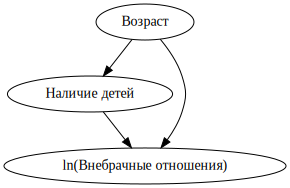

In [30]:
g = gr.Digraph()
g.node('X', 'Возраст')
g.node('T', 'Наличие детей')
g.node('Y', 'ln(Внебрачные отношения)')
g.edges(['XT', 'XY', 'TY'])
display(g)

In [31]:
#загрузим данные
data = pd.DataFrame(sm.datasets.fair.load().data)[['affairs', 'children', 'age']]
# берем тех, у кого были внебрачные отношения
data = data[data['affairs'] > 0]
data['log_affairs'] = np.log(data['affairs'])
# делаем признак наличие детей бинарным
data['children'] = data['children'].apply(lambda cnt: (cnt > 0))
data

,affairs,children,age,log_affairs
0,0.111111,True,32.0,-2.197225
1,3.230769,True,27.0,1.172720
2,1.400000,False,22.0,0.336472
3,0.727273,True,37.0,-0.318454
4,4.666666,True,27.0,1.540445
...,...,...,...,...
2048,1.217391,True,32.0,0.196710
2049,0.521739,True,37.0,-0.650588
2050,4.900000,True,22.0,1.589235
2051,1.507691,False,32.0,0.410580


Теперь построим граф для модели DoWhy

In [32]:
causal_graph = nx.DiGraph([
    ('age', 'children'), 
    ('age', 'log_affairs'),
    ('children', 'log_affairs')
])

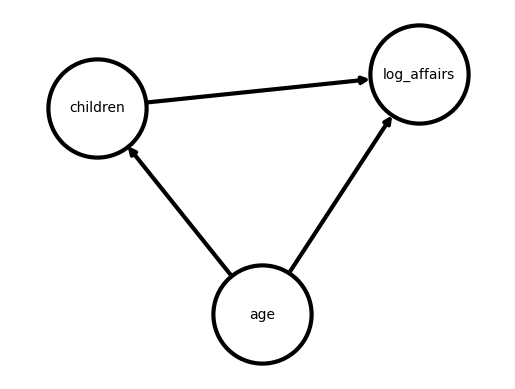

In [33]:
options = {
    "font_size": 10,
    "node_size": 5000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 3,
    "width": 3,
}

nx.draw_networkx(causal_graph, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

Определяем модель и обучаем ее

In [34]:
causal_model = gcm.StructuralCausalModel(causal_graph)

causal_model.set_causal_mechanism('age', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('children', gcm.ClassifierFCM())
causal_model.set_causal_mechanism(
    'log_affairs', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor())
)

gcm.fit(causal_model, data)

Fitting causal mechanism of node log_affairs: 100%|█| 3/3 [00:00<00:00, 21.72it/


Посчитаем $ATE$. Вспомним из лекции, что $ATE = E(Y| T := 1) - E(Y| T := 0).$

Проведем интервенции $T := 1, \ T := 0,$ сделаем семпл из данных, посчитаем среднее и возьмем их разность. Таким образом мы получим оценку $ATE$.

In [35]:
num_samples_to_draw = 1_000_000
interventional_mean = []

for t in [False, True]:
    samples = gcm.interventional_samples(
        causal_model,
        {'children': lambda z: t},  # условие интервенции
        num_samples_to_draw=num_samples_to_draw  # количество семплирований
    )
    interventional_mean.append(samples.astype(int).mean())

ate = interventional_mean[1]['log_affairs'] - interventional_mean[0]['log_affairs']
print(f'влияние наличия детей на логарифм времени во внебрачных отношениях: {np.round(ate, 3)}')

влияние наличия детей на логарифм времени во внебрачных отношениях: -0.34


**Вывод:** наличие детей отрицательно влияет на логарифм времени во внебрачных отношениях. Это значит, что пары, имеющие детей, меньше времени изменяют.